__Ray Tracing__

In the last tutorial, our use of planes was a bit clunky. We manually had to input grids to trace them, and keep track of which grids were image-plane grids and which were source plane al. It was easy to make mistakes!

Fotunately, in PyAutoLens, you won't actually spend much hands-on time with the plane module. Instead, you'll primarily use the 'ray-tracing' module, which we'll cover in this example. Lets look at how easy it is to setup the same lens-plane + source-plane strong lens configuration as the previous tutorial, but with a lot less lines of code!

In [2]:


import autolens as al
import autolens.plot as aplt
%matplotlib inline

Let use the same grid we've all grown to know and love by now!

In [3]:
image_plane_grid = al.grid.uniform(
    shape_2d=(100, 100), pixel_scales=0.05, sub_size=2
)

For our lens galaxy, we'll use the same SIS mass profile as before.

In [4]:
sis_mass_profile = al.mp.SphericalIsothermal(
    centre=(0.0, 0.0), einstein_radius=1.6
)

lens_galaxy = al.Galaxy(redshift=0.5, mass=sis_mass_profile)

print(lens_galaxy)

Redshift: 0.5
Mass Profiles:
SphericalIsothermal
centre: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0


And for our source galaxy, the same Sersic light profile

In [5]:
sersic_light_profile = al.lp.SphericalSersic(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0
)

source_galaxy = al.Galaxy(redshift=1.0, light=sersic_light_profile)

print(source_galaxy)

Redshift: 1.0
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 1.0
effective_radius: 1.0
sersic_index: 1.0


Now, lets use the lens and source galaxies to ray-trace our grid, using a 'tracer' from the ray-tracing module. When we pass our galaxies into the Tracer below, the following happens:

1) The galaxies are ordered in ascending redshift.
2) Planes are created at every one of these redshifts, with the galaxies at those redshifts associated with those planes.

In [6]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, source_galaxy],
)

This tracer is composed of a list of planes, in this case two planes (the image and source plane).

In [7]:
print(tracer.planes)

[<autolens.lens.plane.Plane object at 0x7f34be655610>, <autolens.lens.plane.Plane object at 0x7f34be655650>]


We can access these using the 'image-plane' and 'source-plane' attributes.

In [8]:
print("Image Plane:")
print(tracer.planes[0])
print(tracer.image_plane)
print()
print("Source Plane:")
print(tracer.planes[1])
print(tracer.source_plane)

Image Plane:

Source Plane:


The most convenient part of the tracer is we can use it to perform fully 'ray-traced' images, without manually setting up the planes to do this. The function below does the following

1) Using the lens-galaxy's mass-profile, the deflection angle of every image-plane grid coordinate is computed.
2) These deflection angles are used to trace every image-plane coordinate to a source-plane coordinate.
3) The light of each traced source-plane coordinate is evaluated using the source-plane galaxy's light profile.

In [9]:
traced_profile_image = tracer.profile_image_from_grid(grid=image_plane_grid)
print("traced image pixel 1")
print(traced_profile_image.in_2d[0, 0])
print("traced image pixel 2")
print(traced_profile_image.in_2d[0, 1])
print("traced image pixel 3")
print(traced_profile_image.in_2d[0, 2])

traced image pixel 1
0.21426976064802492
traced image pixel 2
0.22070585920172178
traced image pixel 3
0.22730087364082105


This image appears as the Einstein ring we saw in the previous tutorial.

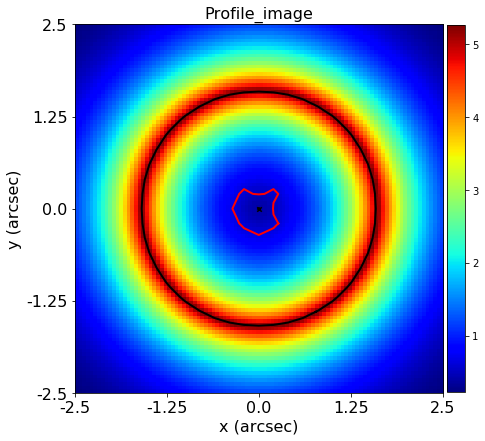

In [10]:
aplt.tracer.profile_image(tracer=tracer, grid=image_plane_grid)

We can also use the tracer to compute the traced grid of every plane, instead of getting the traced image itself:

In [11]:
traced_grids = tracer.traced_grids_of_planes_from_grid(
    grid=image_plane_grid
)

And the source-plane's grid has been deflected.

In [12]:
print("grid source-plane coordinate 1")
print(traced_grids[1].in_2d[0,0])
print("grid source-plane coordinate 2")
print(traced_grids[1].in_2d[0,1])
print("grid source-plane coordinate 3")
print(traced_grids[1].in_2d[0,2])

grid source-plane coordinate 1
[ 1.35612915 -1.35612915]
grid source-plane coordinate 2
[ 1.35042966 -1.3368575 ]
grid source-plane coordinate 3
[ 1.34470204 -1.31767286]


We can use the plane_plotter to plot these grids, like we did before.

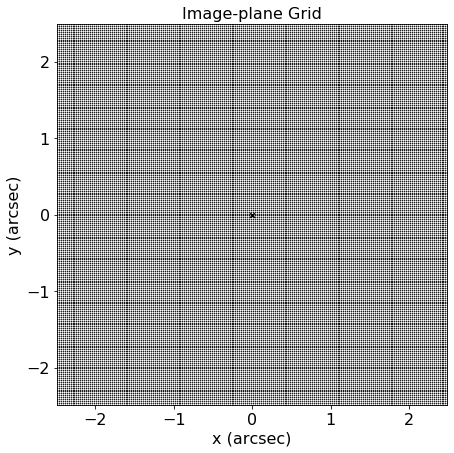

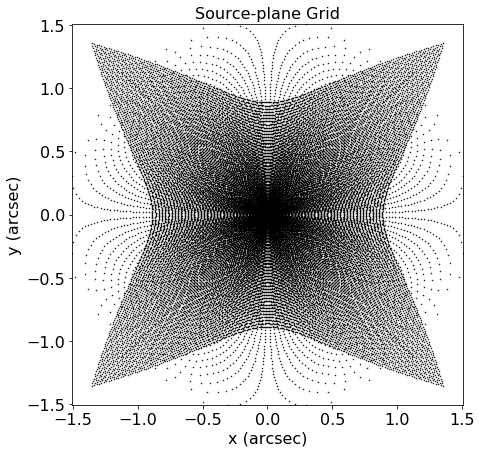

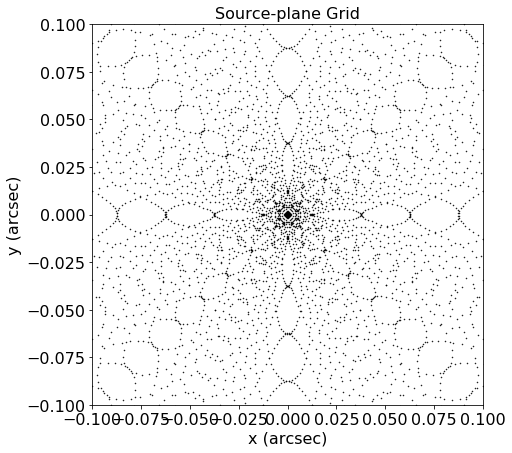

In [13]:
plotter = aplt.Plotter(labels=aplt.Labels(title="Image-plane Grid"))

aplt.plane.plane_grid(plane=tracer.image_plane, grid=traced_grids[0], plotter=plotter)

plotter = aplt.Plotter(labels=aplt.Labels(title="Source-plane Grid"))

aplt.plane.plane_grid(plane=tracer.source_plane, grid=traced_grids[1], plotter=plotter)

aplt.plane.plane_grid(
    plane=tracer.source_plane,
    grid=traced_grids[1],
    axis_limits=[-0.1, 0.1, -0.1, 0.1],
    plotter=plotter,
)

PyAutoLens has tools for plotting a tracer. A ray-tracing subplot plots the following:

1) The image, computed by tracing the source galaxy's light 'forwards' through the tracer.

2) The source-plane image, showing the source galaxy's true appearance (i.e. if it were not lensed).

3) The image-plane convergence, computed using the lens galaxy's mass profile.

4) The image-plane gravitational potential, computed using the lens galaxy's mass profile.

5) The image-plane deflection angles, computed using the lens galaxy's mass profile.

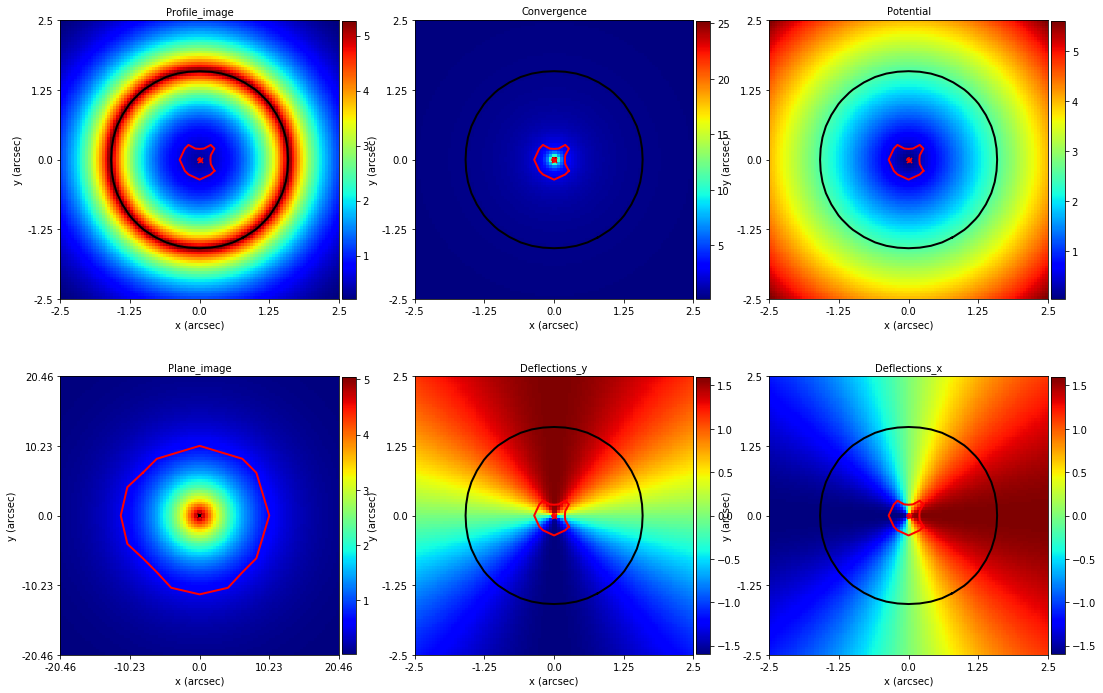

In [14]:
aplt.tracer.subplot_tracer(tracer=tracer, grid=image_plane_grid)

Just like for a plane, these quantities attributes can be computed by passing a grid (converted to 2D NumPy arrays the same dimensions as our input grid!).

In [15]:
convergence = tracer.convergence_from_grid(
    grid=image_plane_grid
)

print("Tracer - Convergence - grid coordinate 1:")
print(convergence.in_2d[0, 0])
print("Tracer - Convergence - grid coordinate 2:")
print(convergence.in_2d[0, 1])
print("Tracer - Convergence - grid coordinate 3:")
print(convergence.in_2d[0, 2])
print("Tracer - Convergence - grid coordinate 101:")
print(convergence.in_2d[1, 0])

Tracer - Convergence - grid coordinate 1:
0.22741122611024647
Tracer - Convergence - grid coordinate 2:
0.22855685270631343
Tracer - Convergence - grid coordinate 3:
0.22970813194808845
Tracer - Convergence - grid coordinate 101:
0.22855685270631343


Of course, these convergences are identical to the image-plane convergences, as it's only the lens galaxy that contributes to the overall mass of the ray-tracing system.

In [16]:
image_plane_convergence = tracer.image_plane.convergence_from_grid(
    grid=image_plane_grid
)

print("Image-Plane - Convergence - grid coordinate 1:")
print(image_plane_convergence.in_2d[0, 0])
print("Image-Plane - Convergence - grid coordinate 2:")
print(image_plane_convergence.in_2d[0, 1])
print("Image-Plane - Convergence - grid coordinate 3:")
print(image_plane_convergence.in_2d[0, 2])
print("Image-Plane - Convergence - grid coordinate 101:")
print(image_plane_convergence.in_2d[1, 0])

Image-Plane - Convergence - grid coordinate 1:
0.22741122611024647
Image-Plane - Convergence - grid coordinate 2:
0.22855685270631343
Image-Plane - Convergence - grid coordinate 3:
0.22970813194808845
Image-Plane - Convergence - grid coordinate 101:
0.22855685270631343


I've left the rest below commented to avoid too many print statements, but if you're feeling adventurous go ahead and uncomment the lines below!

In [17]:
print('Potential:')
print(tracer.potential_from_grid(grid=image_plane_grid))
print(tracer.image_plane.potential_from_grid(grid=image_plane_grid))
print('Deflections:')
print(tracer.deflections_from_grid(grid=image_plane_grid))
print(tracer.deflections_from_grid(grid=image_plane_grid))
print(tracer.image_plane.deflections_from_grid(grid=image_plane_grid))
print(tracer.image_plane.deflections_from_grid(grid=image_plane_grid))

Potential:
[5.62856998 5.60035713 5.60035713 ... 5.60035713 5.60035713 5.62856998]
[5.62856998 5.60035713 5.60035713 ... 5.60035713 5.60035713 5.62856998]
Deflections:
[[ 1.13137085 -1.13137085]
 [ 1.13707034 -1.1256425 ]
 [ 1.1256425  -1.13707034]
 ...
 [-1.1256425   1.13707034]
 [-1.13707034  1.1256425 ]
 [-1.13137085  1.13137085]]
[[ 1.13137085 -1.13137085]
 [ 1.13707034 -1.1256425 ]
 [ 1.1256425  -1.13707034]
 ...
 [-1.1256425   1.13707034]
 [-1.13707034  1.1256425 ]
 [-1.13137085  1.13137085]]
[[ 1.13137085 -1.13137085]
 [ 1.13707034 -1.1256425 ]
 [ 1.1256425  -1.13707034]
 ...
 [-1.1256425   1.13707034]
 [-1.13707034  1.1256425 ]
 [-1.13137085  1.13137085]]
[[ 1.13137085 -1.13137085]
 [ 1.13707034 -1.1256425 ]
 [ 1.1256425  -1.13707034]
 ...
 [-1.1256425   1.13707034]
 [-1.13707034  1.1256425 ]
 [-1.13137085  1.13137085]]


You can also plot the above attributes on individual figures, using appropriate ray-tracing plotter (I've left most commented out again for convinience)

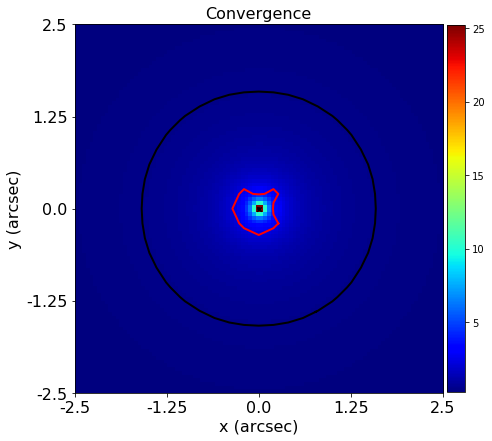

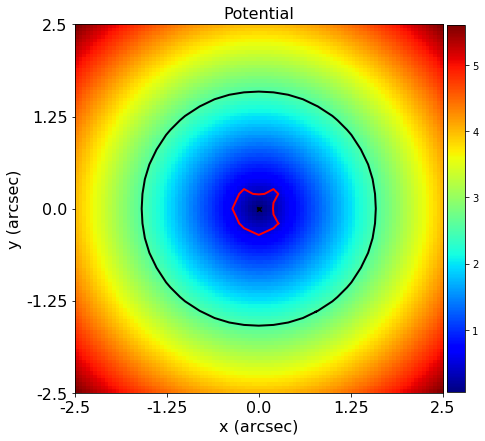

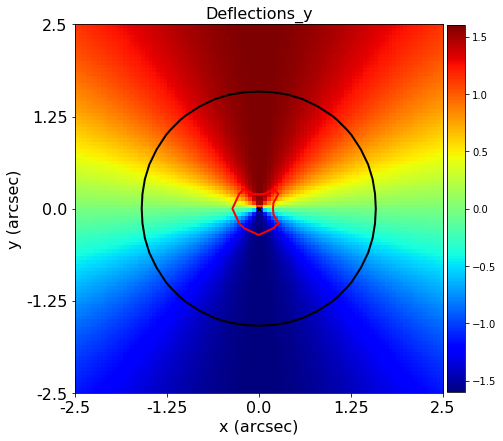

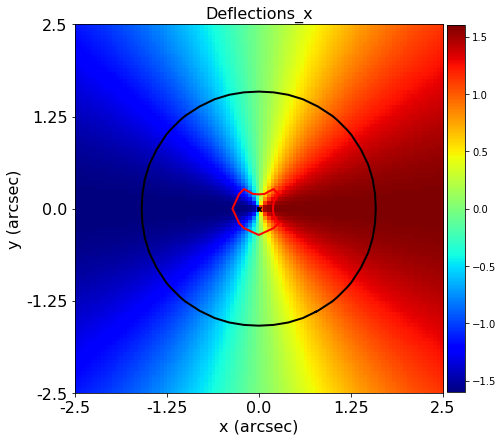

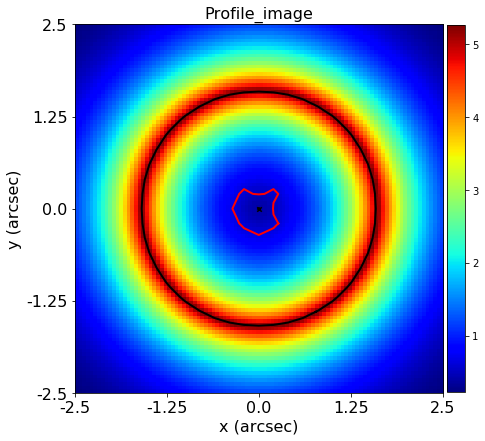

In [19]:
aplt.tracer.convergence(tracer=tracer, grid=image_plane_grid)

aplt.tracer.potential(tracer=tracer, grid=image_plane_grid)
aplt.tracer.deflections_y(tracer=tracer, grid=image_plane_grid)
aplt.tracer.deflections_x(tracer=tracer, grid=image_plane_grid)
aplt.tracer.profile_image(tracer=tracer, grid=image_plane_grid)

Before we finish, you might be wondering 'why do both the image-plane and tracer have the attributes convergence / potential / deflection angles, when the two are identical'. Afterall, only mass profiles contribute to these quantities, and only the image-plane has galaxies with measureable  mass profiles! There are two reasons:

1) Convinience - You could always write 'tracer.image_plane.convergence' and 'aplt.plane.convergence(plane=tracer.image_plane). However, code appears neater if you can just write 'tracer.convergence' and 'aplt.tracer.convergence(tracer=tracer).

2) Multi-plane lensing - For now, we're focused on the simplest lensing configuratio possible, an image-plane + source-plane configuration. However, there are strong lens system where there are more than 2 planes! In these instances, the  convergence, potential and deflections of each plane is different to the overall values given by the tracer.  This is beyond the scope of this chapter, but be reassured that what you're learning now will prepare you for the advanced chapters later on!

And with that, we're done. You've performed your first ray-tracing with PyAutoLens! There are no exercises for this chapter, and we're going to take a deeper look at ray-tracing in the next chapter.